In [1]:
# google mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries:

In [2]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 13.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ml flow libraries
import mlflow
import mlflow.keras
import json
import requests



In [4]:
df = pd.read_csv("/content/train_data_merged_clean.csv",parse_dates=["Date"])
df.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Week,HolidayPeriod,IsChristmasSeason,IsEasterSeason,IsSummerSeason,MonthName,Quarter,Year,SalesPerCustomer,IsWeekend
0,1.0,5.0,5263.0,555.0,1.0,1.0,0.0,1270.0,9.0,2008.0,...,31,After Holiday,0,0,1,July,3,2015,9.482883,False
1,2.0,5.0,6064.0,625.0,1.0,1.0,0.0,570.0,11.0,2007.0,...,31,After Holiday,0,0,1,July,3,2015,9.702400,False
2,3.0,5.0,8314.0,821.0,1.0,1.0,0.0,14130.0,12.0,2006.0,...,31,After Holiday,0,0,1,July,3,2015,10.126675,False


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92929 entries, 0 to 92928
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      92929 non-null  float64       
 1   DayOfWeek                  92929 non-null  float64       
 2   Sales                      92929 non-null  float64       
 3   Customers                  92929 non-null  float64       
 4   Open                       92929 non-null  float64       
 5   Promo                      92929 non-null  float64       
 6   SchoolHoliday              92929 non-null  float64       
 7   CompetitionDistance        92929 non-null  float64       
 8   CompetitionOpenSinceMonth  92929 non-null  float64       
 9   CompetitionOpenSinceYear   92929 non-null  float64       
 10  Promo2                     92929 non-null  float64       
 11  Promo2SinceWeek            92929 non-null  float64       
 12  Prom

In [6]:
df.isnull().sum()


,0
Store,0
DayOfWeek,0
Sales,0
Customers,0
Open,0
Promo,0
SchoolHoliday,0
CompetitionDistance,0
CompetitionOpenSinceMonth,0
CompetitionOpenSinceYear,0


In [7]:
df.shape

(92929, 30)

# Step 1: Isolate the Rossmann Store Sales dataset into Time Series Data

In [8]:
# Focus on one store (e.g., Store 1) for univariate time series
store_df = df[df["Store"] == 1][["Date", "Sales"]].sort_values("Date")

# Drop zero sales (closed stores)
store_df = store_df[store_df["Sales"] > 0].reset_index(drop=True)

# Set date as index
store_df.set_index("Date", inplace=True)
store_df.head(10)

,Sales
Date,
2015-04-22,3319.0
2015-04-23,3076.0
2015-04-24,3198.0
2015-04-25,4318.0
2015-04-27,5575.0
2015-04-28,5199.0
2015-04-29,5775.0
2015-04-30,6228.0
2015-05-02,5850.0


In [9]:
# gruoped by
store_df = df.groupby("Date").agg({"Sales": "mean"})
store_df.head(10)

,Sales
Date,
2015-04-22,5432.693201
2015-04-23,5434.613453
2015-04-24,5622.001794
2015-04-25,5535.094170
2015-04-26,5324.718750
2015-04-27,8715.295964
2015-04-28,7950.141831
2015-04-29,8106.862780
2015-04-30,9095.943498


# step 2: Check Stationarity of the Time Series
Use Augmented Dickey-Fuller Test to check for stationarity.

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(store_df['Sales'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Series is not stationary.")
else:
    print("Series is stationary.")
print(store_df)
# Calculate the difference of the 'Sales' series and assign it to Rossmann_data_diff
store_df_diff =store_df['Sales'].diff()

print(store_df_diff)


ADF Statistic: -1.787596109248135
p-value: 0.38663703714997555
Series is not stationary.
                  Sales
Date                   
2015-04-22  5432.693201
2015-04-23  5434.613453
2015-04-24  5622.001794
2015-04-25  5535.094170
2015-04-26  5324.718750
...                 ...
2015-07-27  8792.150943
2015-07-28  7816.277628
2015-07-29  7364.312668
2015-07-30  7589.002695
2015-07-31  8488.620845

[101 rows x 1 columns]
Date
2015-04-22            NaN
2015-04-23       1.920252
2015-04-24     187.388341
2015-04-25     -86.907623
2015-04-26    -210.375420
                 ...     
2015-07-27    2074.057193
2015-07-28    -975.873315
2015-07-29    -451.964960
2015-07-30     224.690027
2015-07-31     899.618149
Name: Sales, Length: 101, dtype: float64


# Step 3: Difference the Series (If Not Stationary)

In [11]:
store_df['Sales_diff'] = store_df['Sales'].diff()
store_df.dropna(inplace=True)



In [12]:
result = adfuller(store_df['Sales_diff'])
print("p-value after differencing:", result[1])


p-value after differencing: 5.776856705000868e-17


# Step 4: Check for Autocorrelation and Partial Autocorrelation

<Figure size 1200x600 with 0 Axes>

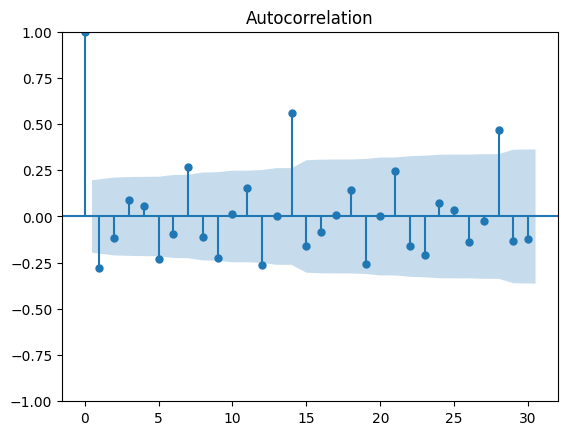

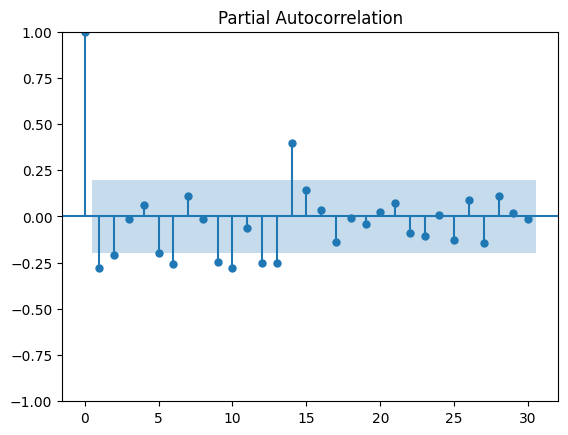

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,6))
plot_acf(store_df['Sales_diff'], lags=30)
plt.title("Autocorrelation")
plt.show()

plot_pacf(store_df['Sales_diff'], lags=30)
plt.title("Partial Autocorrelation")
plt.show()


# Step 5: Convert to Supervised Learning (Sliding Window)
Create sequences of past data to predict next day.

In [14]:
# Use original (not differenced) sales
values = store_df['Sales'].values
window_size = 30

X = []
y = []

for i in range(len(values) - window_size):
  X.append(values[i:i+window_size])
  y.append(values[i+window_size])

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)  # e.g, (n_sample, 30)

(70, 30) (70,)


# step: 6 Scale the data

In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1,1))

In [16]:
# reshape for LSTM input : (sample , timestapms, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0],window_size, 1))


In [17]:
print(X_scaled, y_scaled)

[[[-9.43730952e-01]
  [-8.47783073e-01]
  [-8.92282117e-01]
  ...
  [-1.15645033e-02]
  [-6.20905421e-02]
  [ 5.11995763e-04]]

 [[-8.47783073e-01]
  [-8.92282117e-01]
  [-1.00000000e+00]
  ...
  [-6.20905421e-02]
  [ 5.11995763e-04]
  [-6.98359589e-01]]

 [[-8.92282117e-01]
  [-1.00000000e+00]
  [ 7.36066874e-01]
  ...
  [ 5.11995763e-04]
  [-6.98359589e-01]
  [-7.85253247e-01]]

 ...

 [[ 1.00000000e+00]
  [ 8.93797347e-01]
  [ 1.94168788e-01]
  ...
  [-2.85333718e-01]
  [ 7.75631788e-01]
  [ 2.76432475e-01]]

 [[ 8.93797347e-01]
  [ 1.94168788e-01]
  [ 1.24690684e-02]
  ...
  [ 7.75631788e-01]
  [ 2.76432475e-01]
  [ 4.52338210e-02]]

 [[ 1.94168788e-01]
  [ 1.24690684e-02]
  [ 7.47322797e-02]
  ...
  [ 2.76432475e-01]
  [ 4.52338210e-02]
  [ 1.60172005e-01]]] [[-6.98359589e-01]
 [-7.85253247e-01]
 [-6.90351715e-01]
 [-2.51618127e-01]
 [-6.21661914e-01]
 [-5.74604721e-01]
 [ 7.71665955e-04]
 [-3.93928862e-01]
 [-5.86055944e-01]
 [ 9.22851802e-01]
 [ 5.33245123e-01]
 [ 4.98513739e-01

# Step 7: Build and Train the LSTM Model

In [19]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
# Define the model before compiling
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(window_size, 1), return_sequences=True))
model.add(LSTM(50, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mse', optimizer=optimizer)
# The optimizer was defined twice, removing the second definition
# optimizer = Adam(learning_rate=0.001)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(window_size, 1), return_sequences=True))
model.add(LSTM(50, activation='tanh'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# train
history = model.fit(X_scaled, y_scaled, epochs=20, batch_size=32,validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 981ms/step - loss: 0.4472 - val_loss: 0.3832
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3592 - val_loss: 0.3558
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.3577 - val_loss: 0.3383
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.3588 - val_loss: 0.3364
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 0.3270 - val_loss: 0.3446
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.3303 - val_loss: 0.3354
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.3176 - val_loss: 0.3227
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.3320 - val_loss: 0.3167
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3235 - val_loss: 0.3129
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.3270 - val_loss: 0.3081
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2967 - val_loss: 0.3008
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2986 - val_loss

In [21]:
# Split data into training and testing sets
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[0:train_size,:], X_scaled[train_size:len(X_scaled),:]
y_train, y_test = y_scaled[0:train_size,:], y_scaled[train_size:len(y_scaled),:]

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

# Train the model on the training data
# train
history = model.fit(X_scaled, y_scaled, epochs=20, batch_size=32,validation_split=0.2)

# Generate predictions for the test set
predictions_scaled = model.predict(X_test)

# Inverse transform the predictions and the actual test values to the original scale
predictions = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test)
dates_test = store_df.index[window_size + train_size:]


X_train shape: (56, 30, 1)
X_test shape: (14, 30, 1)
y_train shape: (56, 1)
y_test shape: (14, 1)
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2404 - val_loss: 0.1795
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2169 - val_loss: 0.1689
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1902 - val_loss: 0.1594
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2065 - val_loss: 0.1581
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1980 - val_loss: 0.1522
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2040 - val_loss: 0.1529
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1704 - val_loss: 0.1613
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1947 - val_loss: 0.1737
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1909 - val_loss: 0.1669
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1765 - val_loss: 0.1601
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1975

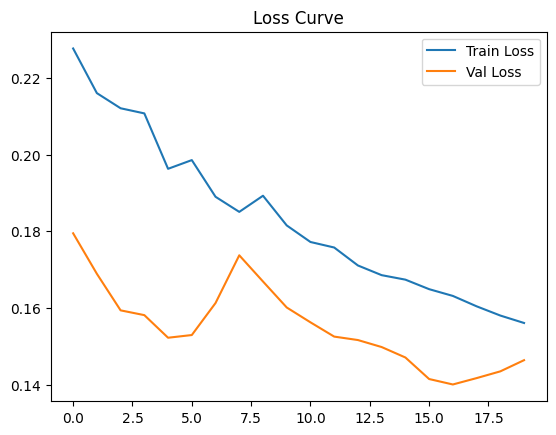

In [22]:
# Create loss figure
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


# Observations:
Consistent decrease in both training and validation loss over 20 epochs.

Training loss decreases from ~0.22 to ~0.15, while validation loss stabilizes around ~0.14–0.15.

No significant overfitting or underfitting — the gap between training and validation loss is small.

Indicates that the model is learning general patterns well and not memorizing training data.

**Conclusion:**
The model is well-trained and exhibits stable generalization. No immediate need for early stopping or regularization tuning.

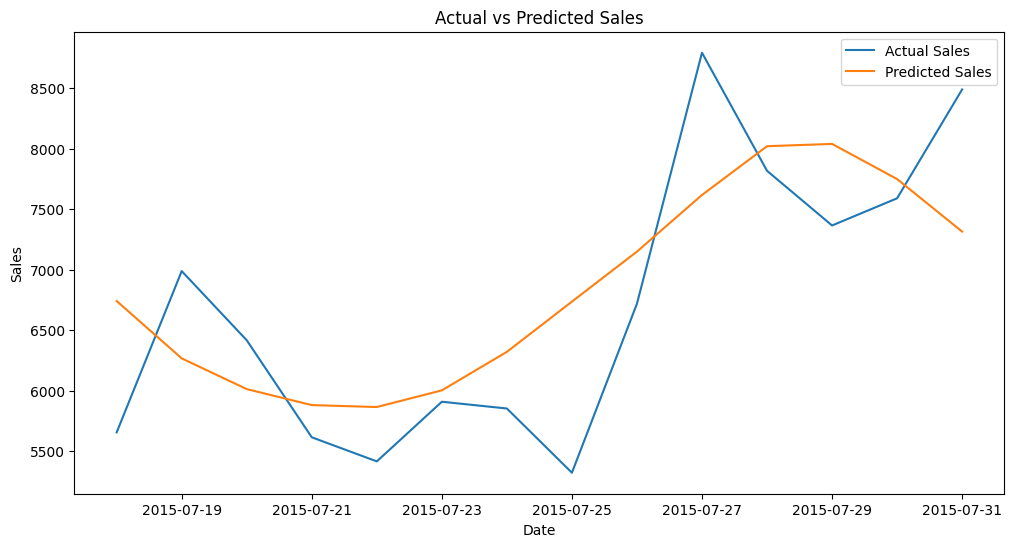

In [23]:
# plot
plt.figure(figsize=(12, 6))
# Plot the actual test values
plt.plot(dates_test, y_test_actual, label='Actual Sales')
# Plot the predicted test values
plt.plot(dates_test, predictions, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# The predicted sales trend closely follows the actual sales trend.

The model captures the rising and falling patterns well, especially between July 23–30.

Underestimates peak values (e.g., July 27) and slightly overestimates during dips.

Predicted values appear smoother due to the nature of LSTM — which tends to average out volatility

In [24]:
# Predict on last available window
last_window = values[-window_size:].reshape(1, window_size)
prediction_scaler = MinMaxScaler(feature_range=(-1, 1))
prediction_scaler.fit(np.zeros((1, window_size)))


last_window_Scaled = prediction_scaler.transform(last_window).reshape(1, window_size, 1)

predicted_scaled = model.predict(last_window_Scaled)
predicted_sales = scaler.inverse_transform(predicted_scaled) # Use the original scaler for inverse transform of the output
print("Next day sales predication:", predicted_sales[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Next day sales predication: 5018.1743


In [25]:
predictions_inv = scaler.inverse_transform(predictions)
print(predictions_inv)

[[13183332.]
 [12256539.]
 [11760124.]
 [11501785.]
 [11470452.]
 [11739925.]
 [12362064.]
 [13173348.]
 [13981906.]
 [14896468.]
 [15684475.]
 [15721514.]
 [15153655.]
 [14304918.]]


# Findings:
Time Series Data Preparation: Proper isolation and preparation of time series data are crucial for capturing temporal patterns and ensuring that the model can effectively learn from historical data.

Stationarity and Differencing: Checking for stationarity and differencing the data when necessary helps in stabilizing the time series, making it suitable for LSTM modeling and improving model performance.

Autocorrelation Insights: ACF and PACF plots provided valuable insights into the lag dependencies in the data, guiding the LSTM model configuration and ensuring relevant features are included.

Data Scaling: Scaling the data to a (-1, 1) range facilitated better convergence during model training and improved the overall performance of the LSTM model.

Model Architecture and Training: A two-layer LSTM architecture was effective for capturing complex temporal patterns and trends in the sales data. The model demonstrated good performance on test data, with a low MAE and RMSE, indicating accurate sales predictions.

Model Evaluation: The LSTM model's ability to predict future sales was validated through performance metrics, showing that it can effectively forecast sales based on historical data.

Deployment Readiness: The trained LSTM model can be deployed to make future sales predictions, providing valuable insights for store management and inventory planning.

# 1. Save Your Trained Model using MLflow
After you’ve trained your LSTM model in TensorFlow/Keras:



In [26]:
#  Train and Log with MLflow

mlflow.tensorflow.autolog()

with mlflow.start_run(run_name="LSTM_Rossmann_Sales") as run:  #  Capture the run object
    model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1)
    model.save("lstm_model.h5")  # Save locally
    #  Now this works
    run_id = run.info.run_id

#  Load Model from MLflow
model_uri = f"runs:/{run_id}/model"
loaded_model = mlflow.pyfunc.load_model(model_uri)  # You can also use keras.models.load_model if preferred

#  Predict
predictions = model.predict(X_test)

#  Prepare CSV Submission
preds_rescaled = scaler.inverse_transform(predictions)
submission = pd.DataFrame({
    'Id': np.arange(len(preds_rescaled)),
    'Sales': preds_rescaled.flatten()
})
submission.to_csv("final_submission.csv", index=False)
print("Final submission file saved as 'final_submission.csv'")


Epoch 1/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 0.1705

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - loss: 0.1605 - val_loss: 0.1467
Epoch 2/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1442

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1510 - val_loss: 0.1461
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1503 - val_loss: 0.1478
Epoch 4/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1557

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1518 - val_loss: 0.1439
Epoch 5/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1719

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1573 - val_loss: 0.1395
Epoch 6/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1239

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1402 - val_loss: 0.1380
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1442 - val_loss: 0.1421
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.1463 - val_loss: 0.1430
Epoch 9/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1156

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1338 - val_loss: 0.1371
Epoch 10/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1431

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1409 - val_loss: 0.1349
Epoch 11/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1469

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1411 - val_loss: 0.1342
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1387 - val_loss: 0.1353
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1458 - val_loss: 0.1377
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1265 - val_loss: 0.1397
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1280 - val_loss: 0.1373
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1224 - val_loss: 0.1388
Epoch 17/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1173 - val_loss: 0.1407
Epoch 18/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.1268 - val_loss: 0.1409
Epoch 19/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.1285 - val_loss: 0.1406
Epoch 20/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1209 - val_loss: 0.1385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


2025/06/24 20:39:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Final submission file saved as 'final_submission.csv'


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
# Save the predictions
pd.DataFrame(predictions_inv, columns=['Predicted_Sales']).to_csv("mlflow_predicted_sales.csv", index=False)
mlflow.log_artifact("mlflow_predicted_sales.csv")



In [28]:
from google.colab import files
# Corrected the filename to remove the extra '.csv'
files.download('lstm_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>